<a href="https://colab.research.google.com/github/amintapan/chest_xray/blob/master/w4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

from IPython.display import clear_output

%matplotlib inline

In [0]:
!pip install tensorflow-gpu
!pip install h5py

clear_output()

In [0]:
!wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/41d542e7-7f91-47f6-9ff2-dd8e5a5a7861/ChestXRay2017.zip

clear_output()

In [0]:
import tensorflow

In [0]:
!ls

ChestXRay2017.zip  sample_data


In [0]:
from zipfile import ZipFile

with ZipFile("./ChestXRay2017.zip", "r") as f:
    f.extractall(path = "./")

In [0]:
!ls

chest_xray  ChestXRay2017.zip  __MACOSX  sample_data


In [0]:
!ls chest_xray

test  train


In [0]:
from pathlib import Path

train_files = "./chest_xray/train/"
test_files = "./chest_xray/test/"

positive_class_folder_name = "PNEUMONIA"
negative_class_folder_name = "NORMAL"

In [0]:
# training files

# number of X-RAYS which show Pneumonia
P = Path(train_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(train_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Training-Normal - %i " % len(temp))

Training-Pneumonia - 3883 
Training-Normal - 1349 


In [0]:
# testing files

# number of X-RAYS which show Pneumonia
P = Path(test_files + positive_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Pneumonia - %i " % len(temp))

# number of X-RAYS which are normal
P = P = Path(test_files + negative_class_folder_name + "/")
temp = list(P.glob("*.jpeg"))
print("Testing-Normal - %i " % len(temp))

Testing-Pneumonia - 390 
Testing-Normal - 234 


In [0]:
# creating ImageDataGenerators for training

"""
The training data generator must have other augmentation parameters in addition to the rescaling
parameter `rescale`.

Why?

-   The model needs to trained to learn to focus on the essential pieces that determine the answer
    inspite of the possible variations it may find in new X-RAY images. Augmentation parameters like
    random zooming and flipping simulate unpredictable variations
-   The test images should be just like the real-life examples of X-RAY images: they don't have the simulated
    effects like those in the training data.
-   The images used for validation during training must also be like the test-images.
    
"""


from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(featurewise_center = True,
                                     shear_range = 0.2,
                                     rescale = 1.0/255,
                                     horizontal_flip = True,
                                     validation_split = 0.2)

test_generator = ImageDataGenerator(rescale = 1.0/255)

In [0]:
# create batch iterators for the train, validation and test data

train_iterator = train_generator.flow_from_directory(train_files, 
                                                     target_size = (150, 150),
                                                     classes = [positive_class_folder_name, negative_class_folder_name],
                                                     batch_size = 256, 
                                                     shuffle = True, 
                                                     class_mode = "binary",
                                                     subset = "training")
                                                    
validation_iterator = train_generator.flow_from_directory(train_files, 
                                                          target_size = (150, 150),
                                                          classes = [positive_class_folder_name, negative_class_folder_name],
                                                          batch_size = 128, 
                                                          shuffle = False, 
                                                          class_mode = "binary",
                                                          subset = "validation")

test_iterator = test_generator.flow_from_directory(test_files, 
                                                   target_size = (150, 150), 
                                                   classes = [positive_class_folder_name, negative_class_folder_name],
                                                   batch_size = 64, 
                                                   shuffle = False,
                                                   class_mode = "binary")

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# count for class instances in training data

class1 = sum(train_iterator.classes)
class0 = len(train_iterator.classes) - class1

print("Label 0 - %i, Label 1 - %i" % (class0, class1))

Label 0 - 3107, Label 1 - 1080


In [0]:
# count for class instances in validation data

class1 = sum(validation_iterator.classes)
class0 = len(validation_iterator.classes) - class1

print("Label 0 - %i, Label 1 - %i" % (class0, class1))

Label 0 - 776, Label 1 - 269


In [0]:
# count for class instances in testing data

class1 = sum(test_iterator.classes)
class0 = len(test_iterator.classes) - class1

print("Label 0 - %i, Label 1 - %i" % (class0, class1))

Label 0 - 390, Label 1 - 234


In [0]:
# defining category label weights as per imbalance amount of the training dataset

from sklearn.utils.class_weight import compute_class_weight

y = train_iterator.classes
labels = np.unique(y)

train_class_weights = compute_class_weight("balanced", labels, y)
train_class_weights

array([0.67380109, 1.93842593])

In [0]:
# are the Colab GPUs available to tensorflow?

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14475778504157570472
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8279868182448311174
physical_device_desc: "device: XLA_CPU device"
]


In [0]:
from tensorflow.keras.backend import clear_session

from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, BatchNormalization, Dense

from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [0]:
clear_session()

base_model = InceptionV3(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))
clear_output()

base_model.trainable = False
myModel = Sequential([base_model,
                      GlobalAveragePooling2D(),
                      Dense(1024, activation = "relu"),
                      Dropout(0.3),
                      Dense(512, activation = "relu"),
                      Dropout(0.3),
                      Dense(256, activation = "relu"),
                      Dropout(0.3),
                      Dense(128, activation = "relu"),
                      Dropout(0.3),
                      Dense(1, activation = "sigmoid")])

myModel.compile(RMSprop(), loss = "binary_crossentropy", metrics = ["accuracy"])
myModel.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
____________________________

In [0]:
history = myModel.fit_generator(train_iterator, 
                                steps_per_epoch = len(train_iterator),
                                epochs = 10,
                                verbose = 1,
                                workers = 20,
                                validation_data = validation_iterator, 
                                validation_steps = len(validation_iterator),
                                class_weight = train_class_weights)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
17/17 [==============================] - 366s 22s/step - loss: 0.7979 - acc: 0.7284 - val_loss: 10.7139 - val_acc: 0.7426
Epoch 2/10
17/17 [==============================] - 344s 20s/step - loss: 0.5687 - acc: 0.7824 - val_loss: 0.4627 - val_acc: 0.8067
Epoch 3/10
17/17 [==============================] - 342s 20s/step - loss: 0.3780 - acc: 0.8405 - val_loss: 0.3995 - val_acc: 0.8478
Epoch 4/10
17/17 [==============================] - 344s 20s/step - loss: 0.3642 - acc: 0.8550 - val_loss: 1.9307 - val_acc: 0.7435
Epoch 5/10
17/17 [==============================] - 341s 20s/step - loss: 0.2709 - acc: 0.8892 - val_loss: 0.5566 - val_acc: 0.8431
Epoch 6/10
17/17 [==============================] - 338s 20s/step - loss: 0.3391 - acc: 0.8722 - val_loss: 0.3565 - val_acc: 0.8651
Epoch 7/10
17/17 [==============================] - 342s 20s/step - loss: 0.2323 - acc: 0.9028 - val_loss: 3.2120 - val_acc: 0.7426
Epoch 8/10
17/17 [==============================] - 340s 20s/step - loss: 0

In [0]:
save_model(myModel, "./myModel_after_10_epochs", overwrite = True, include_optimizer = True)

In [0]:
myModel = load_model("./myModel_after_10_epochs")

In [0]:
from sklearn.metrics import classification_report


yhat = myModel.predict_generator(test_iterator,
                                 steps = len(test_iterator),
                                 verbose = 0)  
mask = yhat > 0.5
yhat[mask] = 1
yhat[~mask] = 0

y = test_iterator.classes

target_names = [positive_class_folder_name, negative_class_folder_name]
print(classification_report(y, yhat, target_names = target_names))

              precision    recall  f1-score   support

   PNEUMONIA       0.74      0.79      0.76       390
      NORMAL       0.61      0.53      0.56       234

    accuracy                           0.69       624
   macro avg       0.67      0.66      0.66       624
weighted avg       0.69      0.69      0.69       624



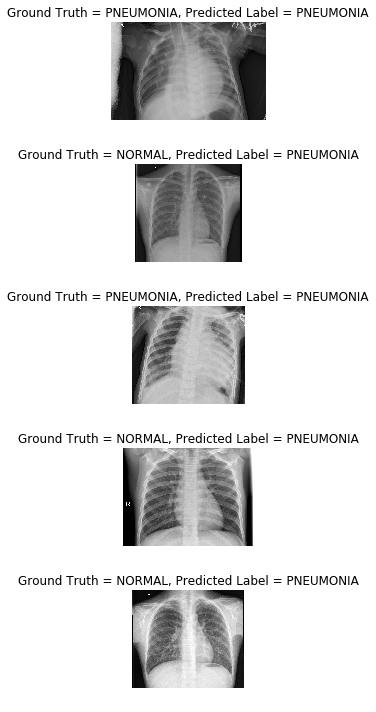

In [0]:
from random import randint
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

label_dict = {0:"PNEUMONIA", 1:"NORMAL"}

test_file_names = test_iterator.filenames
n = len(test_file_names)

plt.rcParams["figure.figsize"] = 12, 10

for i in range(5):
    index = randint(0, n - 1)
    file_name = test_files + test_file_names[index]
    
    image = cv2.imread(file_name, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ground_truth_label = label_dict[int(y[index])]
    predicted_label = label_dict[int(yhat[index])]
    
    plt.subplot(5, 1, i + 1)
    plt.axis("off")
    plt.imshow(image)
    
    title = "Ground Truth = " + ground_truth_label + ", Predicted Label = " + predicted_label
    plt.title(title)

plt.tight_layout()
plt.show()